In [1]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Fetch data with filename
def importdata(filename):
    data = pd.read_csv(filename, header=None, sep=',')
    return data

In [3]:
# Sanitize data. Temporarily dropping columns E_regression, Material Composition
def getdata(data):
    data = data.drop([24,25,26], axis=1)
    data = data.drop([0])
    return data

In [4]:
def getgprmetrics(X_train, y_train, X_test, y_test):
    kernel = ConstantKernel() + 1.0 ** 2 * Matern(length_scale=2.0, nu=1.5) + WhiteKernel(noise_level=1)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X_train, y_train)
    # print(gp.kernel_)
    # print(gp.log_marginal_likelihood(gp.kernel_.theta))
    # print(gpr.score(X_test, y_test))
    y_pred, sigma = gp.predict(X_test, return_std=True)
    y_test = y_test.to_numpy(dtype=float)
    y_std = statistics.stdev(y_test)
    residual = abs(y_pred - y_test)
    return residual, sigma, y_std

In [5]:
def getrfmetrics(X_train, y_train, X_test, y_test):
    regressor = RandomForestRegressor(n_estimators=15, random_state=8)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_test = y_test.to_numpy(dtype=float)
    y_residual = abs(y_pred - y_test)
    error = []
    for x in range(len(X_test)):
        preds = []
        for pred in regressor.estimators_:
            preds.append(pred.predict([X_test[x]])[0])
        error.append(statistics.stdev(preds))
    error = np.array(error)
    return y_residual, error, statistics.stdev(y_test)

In [6]:
def prepareplot(res, sigma, stdev, number_of_bins):
    # Define input data -- divide by standard deviation
    model_errors = sigma / stdev
    abs_res = res /stdev

    # Set bins for calculating RMS
    upperbound = np.amax(model_errors)
    lowerbound = np.amin(model_errors)
    bins = np.linspace(lowerbound, upperbound, number_of_bins, endpoint=False)

    # Create a vector determining bin of each data point
    digitized = np.digitize(model_errors, bins)

    # Record which bins contain data (to avoid trying to do calculations on empty bins)
    bins_present = []
    for i in range(1, number_of_bins + 1):
        if i in digitized:
            bins_present.append(i)

    # Calculate RMS of the absolute residuals
    RMS_abs_res = [np.sqrt((abs_res[digitized == bins_present[i]] ** 2).mean()) for i in range(0, len(bins_present))]

    # Set the x-values to the midpoint of each bin
    bin_width = bins[1]-bins[0]
    binned_model_errors = np.zeros(len(bins_present))
    for i in range(0, len(bins_present)):
        curr_bin = bins_present[i]
        binned_model_errors[i] = bins[curr_bin-1] + bin_width/2

    # Fit a line to the data
    model = LinearRegression(fit_intercept=False)
    model.fit(binned_model_errors[:, np.newaxis],
                  RMS_abs_res)  #### SELF: Can indicate subset of points to fit to using ":" --> "a:b"
    xfit = binned_model_errors
    yfit = model.predict(xfit[:, np.newaxis])

    # Calculate r^2 value
    r_squared = r2_score(RMS_abs_res, yfit)
    # Calculate slope
    slope = model.coef_
    
    return model_errors, abs_res, r_squared, slope, binned_model_errors, RMS_abs_res, xfit, yfit

In [7]:
# Prepare data for training
data = importdata('_haijinlogfeaturesnobarrier_alldata.csv')
data = getdata(data)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=0.3)
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
################################# GPR ######################################
# Train GPR model and get relevant data
res, sigma, std = getgprmetrics(X_train, y_train, X_test, y_test)

In [9]:
# Prepare data for plots
number_of_bins = 8
model_errors, abs_res, r_squared, slope, binned_model_errors, RMS_abs_res, xfit, yfit = prepareplot(res, sigma, std, number_of_bins)

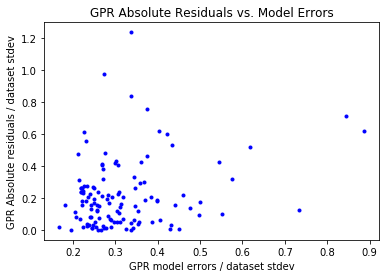

In [10]:
# Create initial scatter plot
plt.xlabel("GPR model errors / dataset stdev")
plt.ylabel("GPR Absolute residuals / dataset stdev")
plt.title("GPR Absolute Residuals vs. Model Errors")
plt.plot(model_errors, abs_res, '.', color='blue');

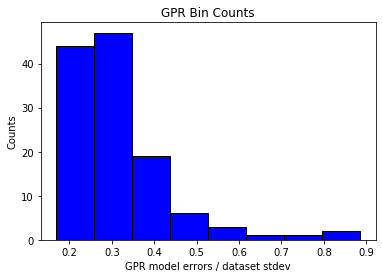

In [11]:
# Histogram of RF error bin counts
plt.hist(model_errors, bins=number_of_bins, color='blue', edgecolor='black')
plt.xlabel("GPR model errors / dataset stdev")
plt.ylabel("Counts")
plt.title("GPR Bin Counts");

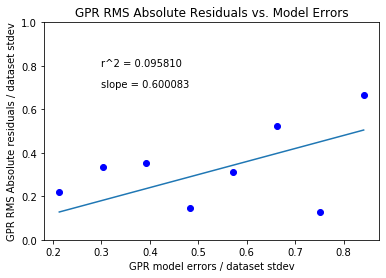

In [12]:
# Create RMS scatter plot
plt.xlabel("GPR model errors / dataset stdev")
plt.ylabel("GPR RMS Absolute residuals / dataset stdev")
plt.ylim(0,1)
plt.title("GPR RMS Absolute Residuals vs. Model Errors")
plt.text(0.3,0.8,'r^2 = %f' %(r_squared))
plt.text(0.3,0.7, 'slope = %f' %(slope))
plt.plot(binned_model_errors, RMS_abs_res, 'o', color='blue')
plt.plot(xfit, yfit);

In [13]:
################################# RFDT ######################################
# Train RF model and get relevant data
res, sigma, std = getrfmetrics(X_train, y_train, X_test, y_test)

In [14]:
# Prepare data for plots
number_of_bins = 8
model_errors, abs_res, r_squared, slope, binned_model_errors, RMS_abs_res, xfit, yfit = prepareplot(res, sigma, std, number_of_bins)

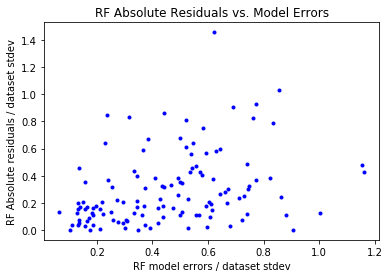

In [15]:
# Create initial scatter plot
plt.xlabel("RF model errors / dataset stdev")
plt.ylabel("RF Absolute residuals / dataset stdev")
plt.title("RF Absolute Residuals vs. Model Errors")
plt.plot(model_errors, abs_res, '.', color='blue');

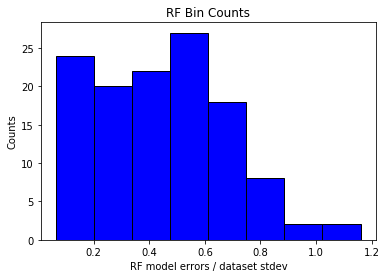

In [16]:
# Histogram of RF error bin counts
plt.hist(model_errors, bins=number_of_bins, color='blue', edgecolor='black')
plt.xlabel("RF model errors / dataset stdev")
plt.ylabel("Counts")
plt.title("RF Bin Counts");

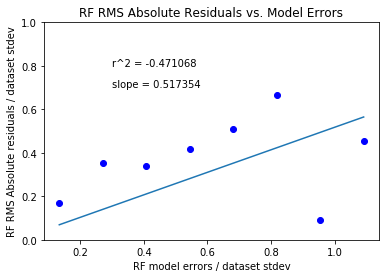

In [17]:
# Create RMS scatter plot
plt.xlabel("RF model errors / dataset stdev")
plt.ylabel("RF RMS Absolute residuals / dataset stdev")
plt.ylim(0,1)
plt.title("RF RMS Absolute Residuals vs. Model Errors")
plt.text(0.3,0.8,'r^2 = %f' %(r_squared))
plt.text(0.3,0.7, 'slope = %f' %(slope))
plt.plot(binned_model_errors, RMS_abs_res, 'o', color='blue')
plt.plot(xfit, yfit);